# Imports and Defines

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# %load detect_sum.py
"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data."""

from __future__ import division, print_function
import numpy as np

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.
    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).
    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.
    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.
    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.
    See this IPython Notebook [2]_.
    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb
    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)
    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)
    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

In [3]:
# Define Univariate Time-Series
#    df: Dataframe with an index and a value column
#    title: Title of data being used
#    serie: Serie 'Name' 
#    xlab: Label of df.index
#    ylab: Label of df.values
#    seasonal_periods: The repetition cycle


#df = dr.DataReader("CPIAUCSL", "fred", start="1947-01-01", end="2019-09-01")
#title = "CPIAUCSL: All Items in U.S. City Average"
#serie = "CPIAUCSL"
#xlab = "Months/Year"; 
#ylab = "Consumer Price Index";
#seasonal_periods = 12

#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#title = "Vehicle Miles Traveled";
#serie = "VMT"
#xlab = "Months/Year";
#ylab = "Miles Traveled (Millions)";
#seasonal_periods = 12

#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.to_datetime(df.index)
#df = df.truncate(before='2002-01-01', after='2019-09-27')
#title = 'PSI20: Historical Closing Prices'
#serie = PSI20
#xlab = 'Business Days/Year'; 
#ylab = 'Closing Price (Euro)';
#seasonal_periods = 5

df = dr.data.get_data_yahoo("SPY", start="1993-01-29", end="2019-09-27")
df = df[['Close']]
title = 'SPY: Historical Closing Prices'
serie = "SPY"
xlab = 'Business Days/Year'; 
ylab = 'Closing Price (Dollar)';
seasonal_periods = 5

# Type of model we expect: 
# 'additive' - Amplitude of the seasonal effect is the same each year
# 'multiplicative' - Seasonal and other effects act proportionally on the series
# Note: By applying log scale to the data you can transform a multiplicative model to an additive
model_type = 'multiplicative' 

# Data Inspection

In [4]:
df.head()

,Close
Date,
1993-01-29,43.93750
1993-02-01,44.25000
1993-02-02,44.34375
1993-02-03,44.81250
1993-02-04,45.00000


In [5]:
# Check the type of data (i.e. float64, integer, ...)
# Check that the number of entries matches number of non-null elements, 
#otherwise we need to take care of the missing elements. 
# Either by replacing them with fillna() or by dropping them dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6715 entries, 1993-01-29 to 2019-09-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6715 non-null   float64
dtypes: float64(1)
memory usage: 104.9 KB


In [6]:
# Visualize first and last 3 samples of the time series
# This allows to see the type of data we are dealing with (and a grasp about their range)
df.head(3).append(pd.DataFrame([[".."]], columns=df.columns)).append(df.tail(3))

,Close
1993-01-29 00:00:00,43.9375
1993-02-01 00:00:00,44.25
1993-02-02 00:00:00,44.3438
0,..
2019-09-25 00:00:00,297.62
2019-09-26 00:00:00,297
2019-09-27 00:00:00,295.4


In [7]:
# Summary statistics
print(df.describe(percentiles=[.1, .25, .5, .75, .9]))
print("var    %.6f" % np.var(df))

             Close
count  6715.000000
mean    135.370791
std      61.333276
min      43.406250
10%      58.218750
25%      97.492188
50%     124.989998
75%     153.735001
90%     227.703995
max     302.010010
var    3761.210543


# Data Visualization

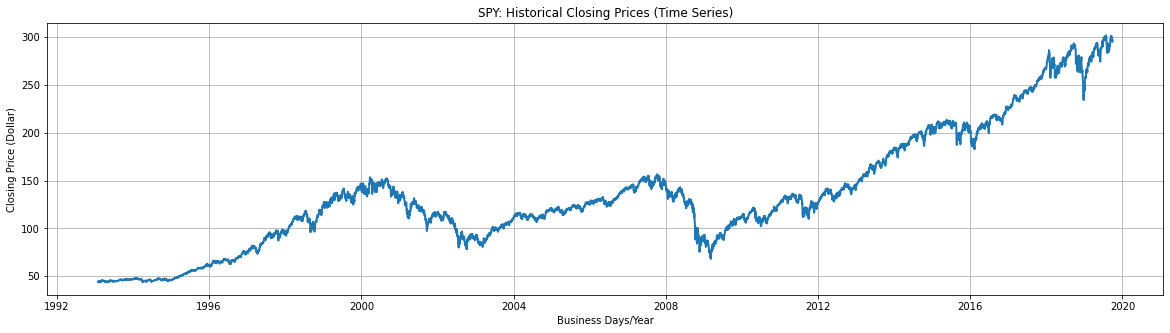

In [8]:
# Let's visualize the data to have an idea of what we are looking at
plt.figure(figsize=(20,5))
plt.plot(df.index, df.values, LineWidth=2)
plt.title(title + ' (Time Series)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid(True)

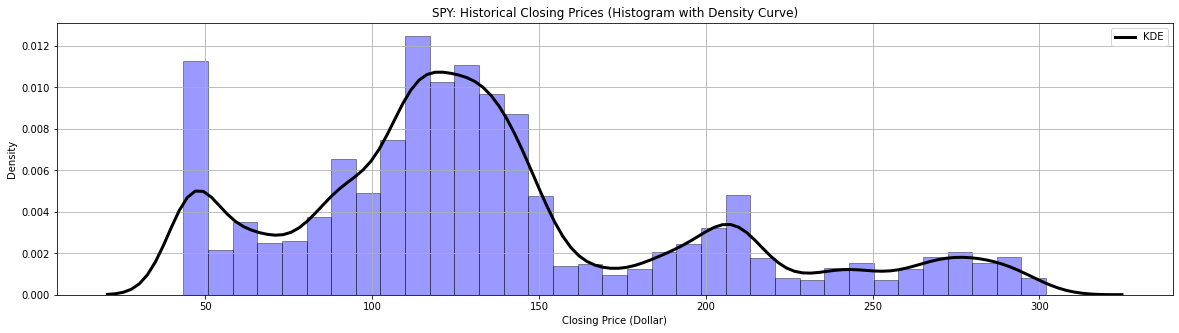

In [9]:
# Histogram plot with depicted density and rug
plt.figure(figsize=(20,5))
sns.distplot(df, 
             bins = 35, color='blue',
             hist = True, hist_kws={'edgecolor':'black'},
             kde = True, kde_kws={"color": "black", "lw": 3, "label": "KDE"},
             # rug = True, rug_kws={'edgecolor':'orange'}
            )
plt.title(title + ' (Histogram with Density Curve)')
plt.ylabel('Density')
plt.xlabel(ylab)
plt.grid(True)

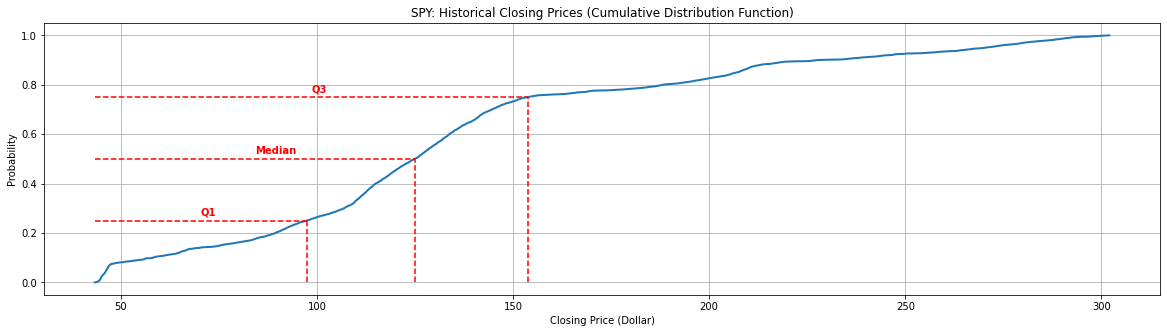

In [10]:
# Cumulative Distribution Function
cdf = df[df.columns.values[0]].value_counts().sort_index().div(len(df)).cumsum()
cdf.plot(figsize=(20,5), LineWidth=2)
plt.title(title + ' (Cumulative Distribution Function)')
plt.ylabel('Probability')
plt.xlabel(ylab)
minVal = df.values.min()
q25 = np.quantile(df.values, .25)
medianVal = np.quantile(df.values, .5)
q75 = np.quantile(df.values, .75)
data=[(minVal, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r', \
      (minVal, medianVal), (.5, .5), 'r', (medianVal, medianVal), (0, .5), 'r', \
      (minVal, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r']
plt.plot(*data, ls='--');
plt.text(minVal+(q25-minVal)/2, 0.27, "Q1", color='r', fontweight='bold')
plt.text(minVal+(medianVal-minVal)/2, 0.52, "Median", color='r', fontweight='bold')
plt.text(minVal+(q75-minVal)/2, 0.77, "Q3", color='r',  fontweight='bold')
plt.grid(True)

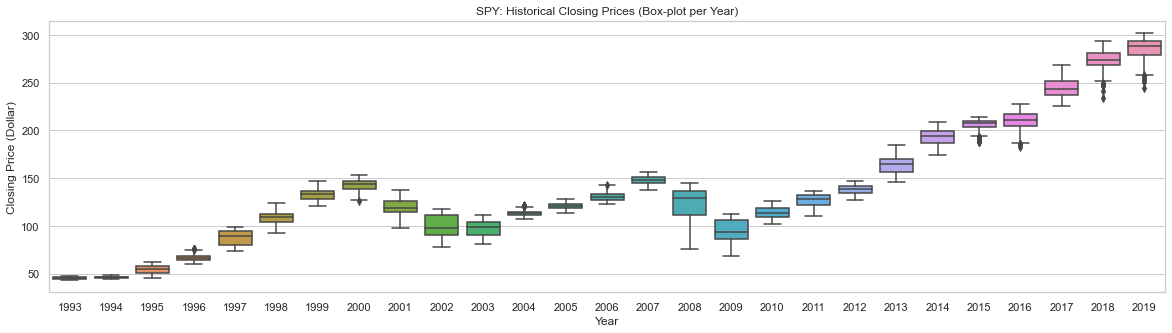

In [11]:
# Box and Whisker plot yearly
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style="whitegrid")
box_plot = sns.boxplot(x=df.index.year, y=df.columns.values[0], data=df);
box_plot.set(xlabel='Year', ylabel=ylab, title= title + ' (Box-plot per Year)');

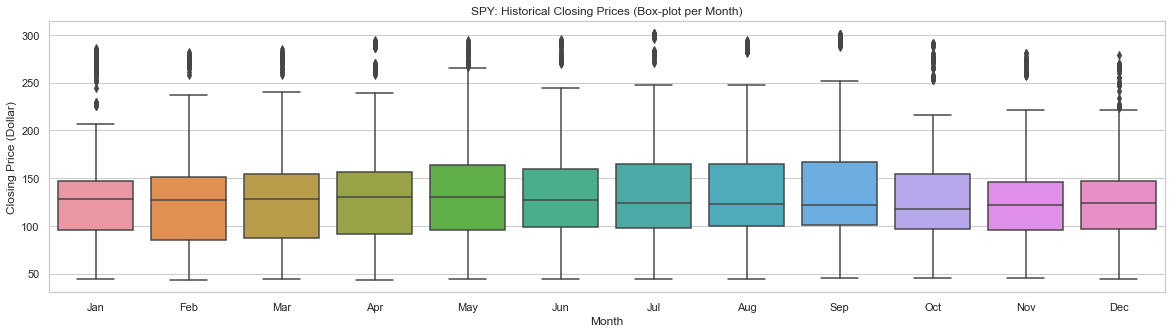

In [12]:
# Box and Whisker plot monthly
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style="whitegrid")
box_plot = sns.boxplot(x=df.index.month, y=df.columns.values[0], data=df);
box_plot.set(xlabel='Month', ylabel=ylab, title= title + ' (Box-plot per Month)');
box_plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

# Data Analysis

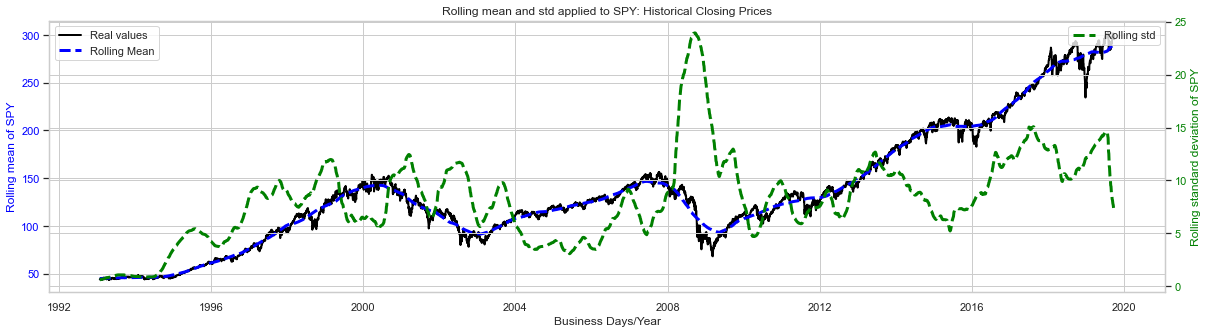

In [13]:
# Let's visually assess data stationarity through rolling mean and std
rolling_window = 300
rolling_mean = df.rolling(rolling_window, center=True, min_periods=1).mean() 
rolling_std  = df.rolling(rolling_window, center=True, min_periods=1).std() 

fig, axMean = plt.subplots(figsize=(20,5))

axMean.plot(df.index, df.values, label = title, linewidth=2, color='black')
axMean.plot(rolling_mean, linestyle='--', linewidth=3, color='blue')
axMean.set_xlabel(xlab)
axMean.set_ylabel('Rolling mean of ' + serie, color='blue')
axMean.legend(['Real values','Rolling Mean'])
axMean.tick_params(axis='y', labelcolor='blue')

axStd = axMean.twinx()
axStd.plot(rolling_std, label='Rolling std', linestyle='--', color='green', linewidth=3)
axStd.set_ylabel(ylab)
axStd.legend(['Rolling std'])
axStd.set_ylabel('Rolling standard deviation of ' + serie, color='green')
axStd.tick_params(axis='y', labelcolor='green')

axMean.set_title('Rolling mean and std applied to ' + title)
plt.show()

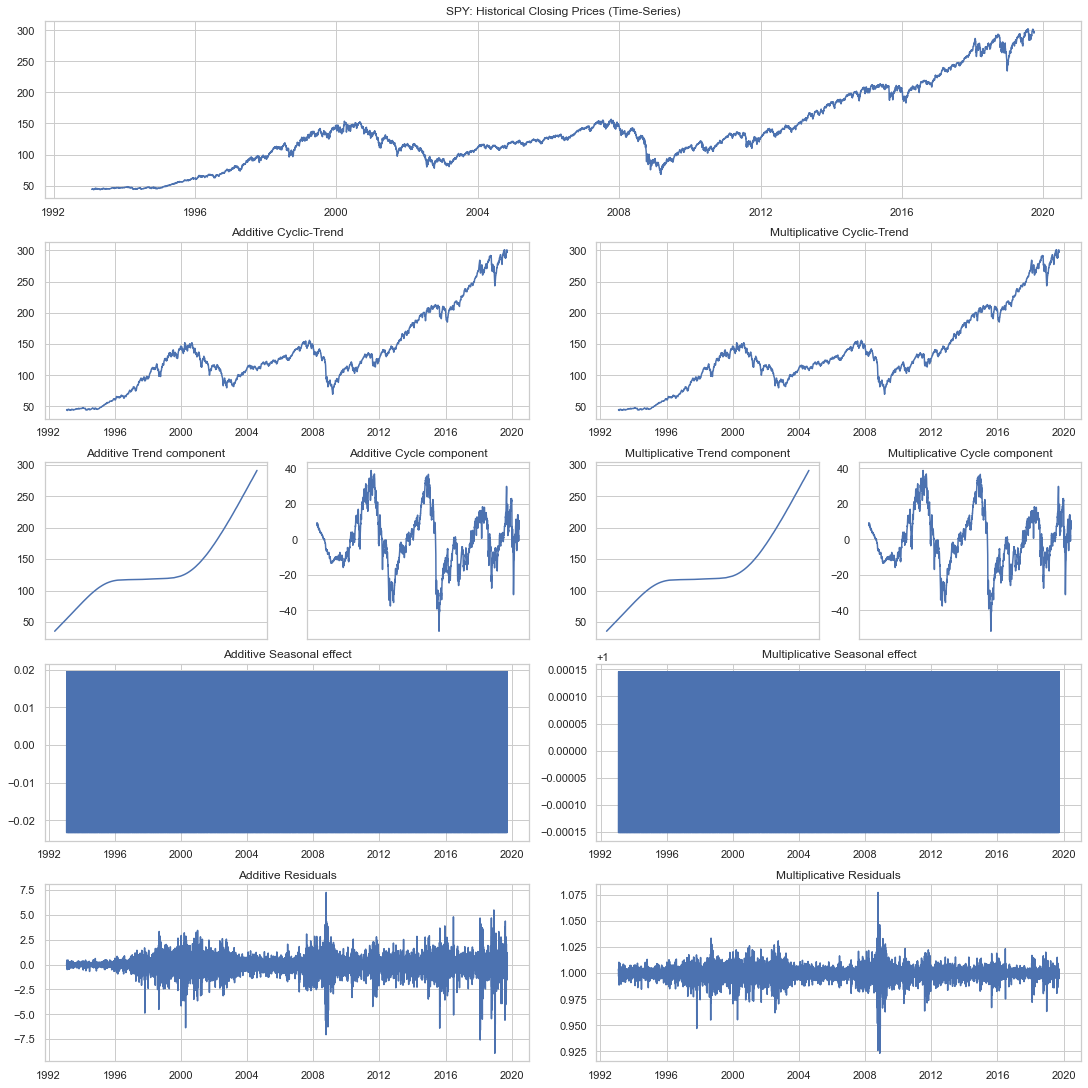

In [14]:
# As it should be known, a time series can typically be decomposed as:
#Additive Time Series = Level + CyclicTrend + Residual + Seasonality 
#Multiplicative Time Series = Level*CyclicTrend*Residual*Seasonality 

# Therefore, we will decompose the time series assuming it is both an additive and multiplicative model
#and we will infer in its type based on the residual fit given at the end

# Seasonal decomposition using moving averages
resultAdd = seasonal_decompose(df, model='additive',       freq=seasonal_periods)
resultMul = seasonal_decompose(df, model='multiplicative', freq=seasonal_periods)
# Hodrick-Prescott filter
# See Ravn and Uhlig: http://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend[resultAdd.trend.notna().values], lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend[resultMul.trend.notna().values], lamb=lamb)

fig = plt.figure(figsize=(15,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

fig.add_subplot(spec[0, :])
plt.plot(df)

plt.title(title + ' (Time-Series)')
# Additive model
fig.add_subplot(spec[1, :2])
plt.plot(resultAdd.trend)
plt.title('Additive Cyclic-Trend')
fig.add_subplot(spec[2, 0])
plt.plot(trendAdd)
plt.xticks([])
plt.title('Additive Trend component')
fig.add_subplot(spec[2, 1])
plt.plot(cycleAdd)
plt.xticks([])
plt.title('Additive Cycle component')
fig.add_subplot(spec[3, :2])
plt.plot(resultAdd.seasonal)
plt.title('Additive Seasonal effect')
fig.add_subplot(spec[4, :2])
plt.plot(resultAdd.resid)
plt.title('Additive Residuals')

# Multiplicative model
fig.add_subplot(spec[1, 2:])
plt.plot(resultMul.trend)
plt.title('Multiplicative Cyclic-Trend')
fig.add_subplot(spec[2, 2])
plt.plot(trendMul)
plt.xticks([])
plt.title('Multiplicative Trend component')
fig.add_subplot(spec[2, 3])
plt.plot(cycleMul)
plt.xticks([])
plt.title('Multiplicative Cycle component')
fig.add_subplot(spec[3, 2:])
plt.plot(resultMul.seasonal)
plt.title('Multiplicative Seasonal effect')
fig.add_subplot(spec[4, 2:])
plt.plot(resultMul.resid)
plt.title('Multiplicative Residuals')
plt.show()

In [18]:
print("Time-Series Level is " + str(round(df.mean(), 2)))
print("")
print("Additive Time Series")
FtAdd = max(0, 1-np.var(resultAdd.resid)/np.var(resultAdd.trend));
print("Strenght of Trend: %.4f" % FtAdd )
FsAdd = max(0, 1-np.var(resultAdd.resid)/np.var(resultAdd.seasonal));
print("Strenght of Seasonality: %.4f" % FsAdd )
print("")
print("Multiplicative Time Series")
FtMul = max(0, 1-np.var(resultMul.resid)/np.var(resultMul.trend));
print("Strenght of Trend: %.4f" % FtMul )
FsMul = max(0, 1-np.var(resultMul.resid)/np.var(resultMul.seasonal));
print("Strenght of Seasonality: %.4f" % FsMul )

Time-Series Level is Close    135.37
dtype: float64

Additive Time Series
Strenght of Trend: 0.9998
Strenght of Seasonality: 0.0000

Multiplicative Time Series
Strenght of Trend: 1.0000
Strenght of Seasonality: 0.0000


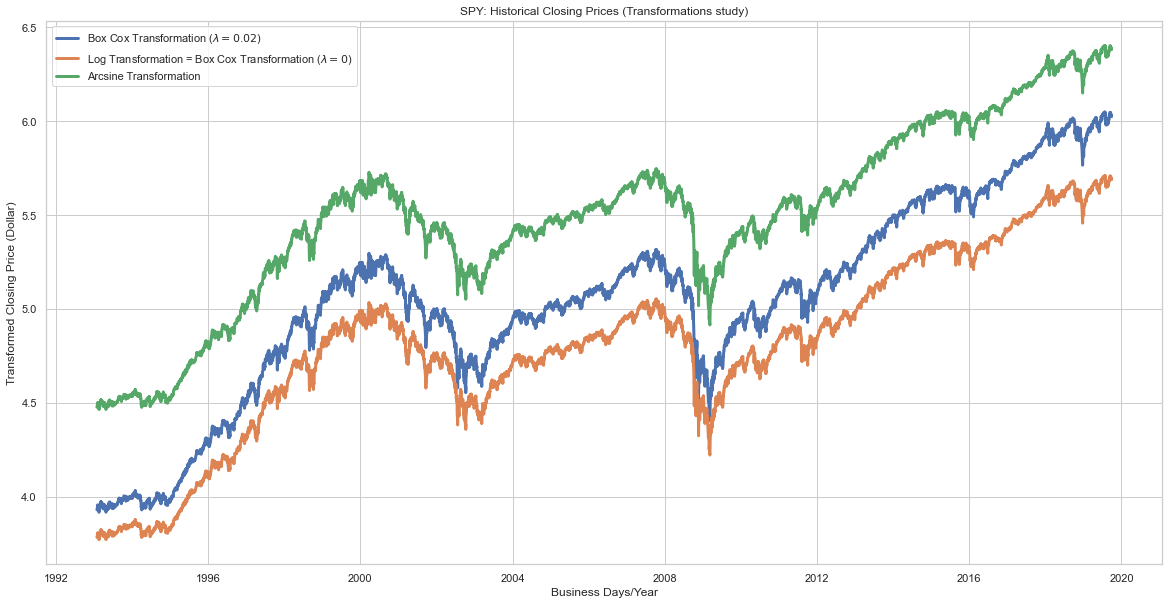

In [25]:
# Data Normalization
fig = plt.figure(figsize=(20,10))
# The Box-Cox transformation intends to transform data to be closer to normality, 
#or tranform heteroskedastic (non constant variance) data to be closer to homoskedasticity (constant variance).
plt.plot(df.index, stats.boxcox(df[df.columns[0]].values, lmbda=.02), label = 'Box Cox Transformation '+u'($\lambda=0.02$)', lw=3)
# The log transform (particular Box-Cox case) can be used where the data has a positively skewed distribution,
#and there are a few very large values. If the latter is in the area of study,
#the transform is likely to make variance more constant and normalize data
plt.plot(df.index, stats.boxcox(df[df.columns[0]].values, lmbda=0), label = 'Log Transformation = Box Cox Transformation '+u'($\lambda=0$)', lw=3)
# The arcsine transformation will help make the variances more constant throughout 
#your study area and often makes the data appear normally distributed as well.
plt.plot(df.index, np.arcsinh(df[df.columns[0]].values), label = 'Arcsine Transformation', lw=3)

plt.legend(loc='best')
plt.title(title + ' (Transformations study)')
plt.xlabel(xlab)
plt.ylabel('Transformed ' + ylab);

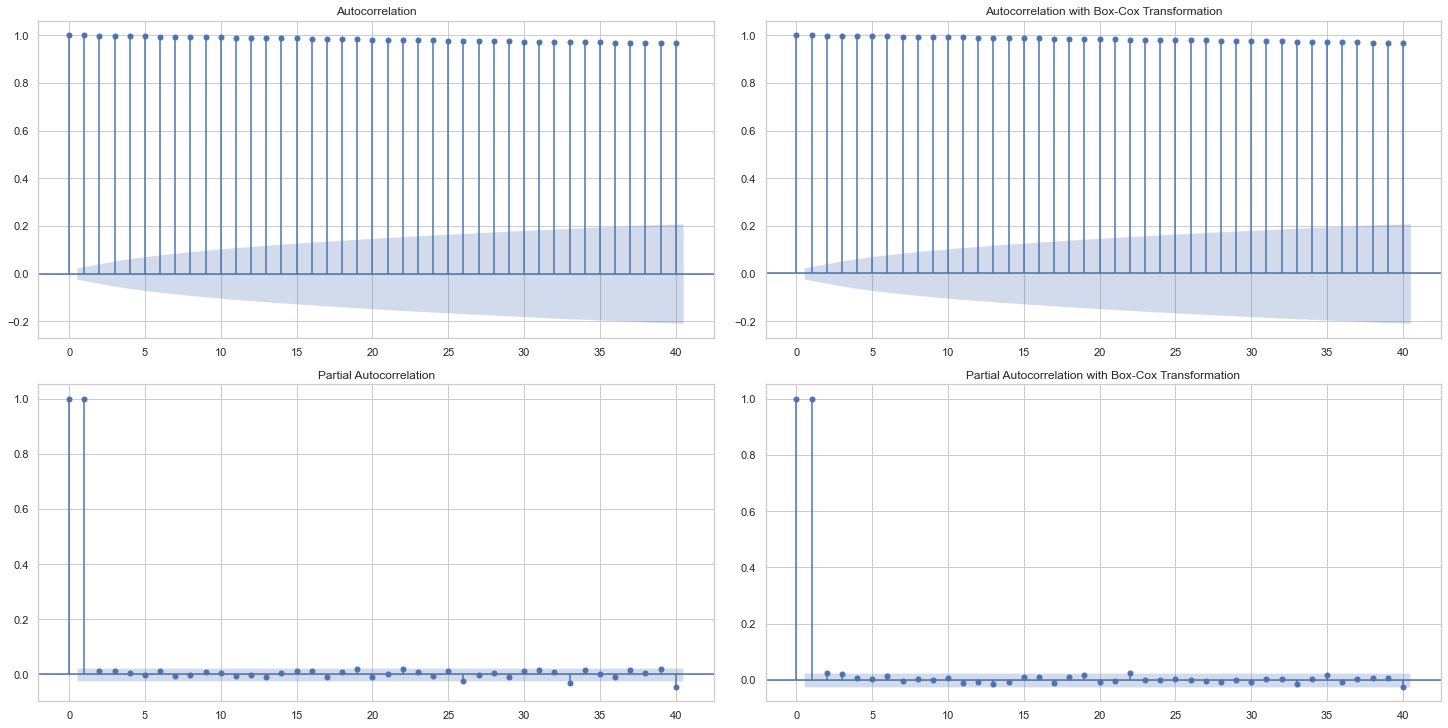

In [27]:
# Correlation plots
maxLags = 40
# The effect of applying Box-Cox transformation against original time series
df_boxCox = stats.boxcox(df[df.columns[0]].values, lmbda=0)

fig = plt.figure(figsize=(20,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df, lags=maxLags, ax=ax_acf)
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df, lags=maxLags, ax=ax_pacf);

# Auto-correlation function for time series transformed with Box-Cox
ax_acfBoxCox = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(df_boxCox, lags=maxLags, ax=ax_acfBoxCox, title='Autocorrelation with Box-Cox Transformation')
# Partial auto-correlation function for time series transformed with Box-Cox
ax_pacfBoxCox = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(df_boxCox, lags=maxLags, ax=ax_pacfBoxCox, title='Partial Autocorrelation with Box-Cox Transformation');


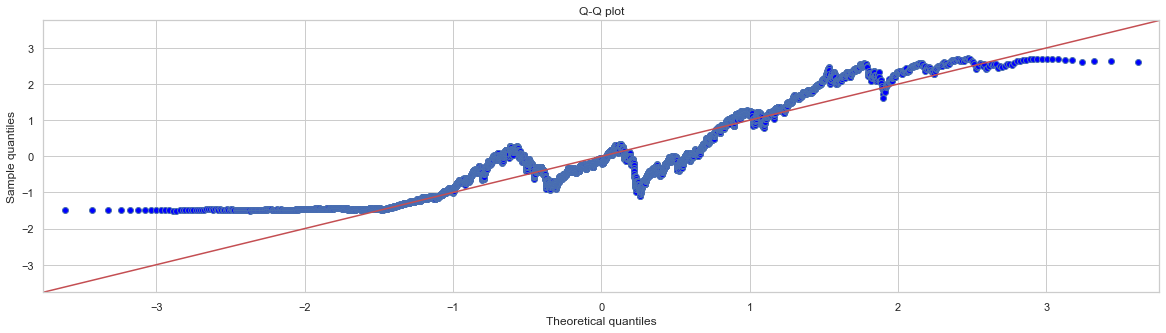

In [28]:
# Q-Q plot
# Compare time series against a standard normal curve
qqplot(df.values, stats.distributions.norm, fit=True, line='45')
plt.title('Q-Q plot');
plt.ylabel('Sample quantiles')
plt.xlabel('Theoretical quantiles')
plt.grid(True)

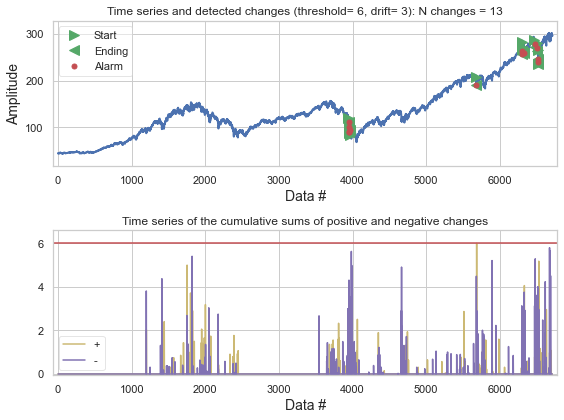

In [39]:
# Suggestions (attention to seasonal series)
# threshold = (max(df.values)-min(df.values))/40
# drift = (max(df.values)-min(df.values))/80
threshold = 6;
drift = 3;

detect_cusum(df.values, threshold, drift, True, True);

# Hypothesis Test

In [30]:
# Kurtosis 
# Measures height and sharpness of the central peak relative to that of a standard bell curve
k, kpval = kurtosistest(df)
kurtosis_val = kurtosis(df, fisher=True)
print("Kurtosis Test for " + serie)
print("Statistic: %.4f" % k[0])
print("p-value: %.4f" % kpval[0])
print(" ")
print("Kurtosis value: %.4f" % kurtosis_val[0])

Kurtosis Test for SPY
Statistic: 2.9758
p-value: 0.0029
 
Kurtosis value: 0.1914


In [31]:
# Skewness
# Measure of the asymmetry of the probability distribution of a random variable about its mean
s, spval = skewtest(df)
skew_val = skew(df)
print("Skew Test for " + serie)
print("Statistic: %.4f" % s[0])
print("p-value: %.4f" % spval[0]) 
print(" ")
print("Skewness value: %.4f" % skew_val[0]) 

Skew Test for SPY
Statistic: 23.9444
p-value: 0.0000
 
Skewness value: 0.8095


In [32]:
# Jarque-Bera goodness of fit test on sample data
# Tests if the sample data has the skewness and kurtosis matching a normal distribution
jb, jbpval= stats.jarque_bera(df)
print("Jarque-Bera Test for " + serie)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)  

Jarque-Bera Test for SPY
Statistic: 743.7061
p-value: 0.0000


In [33]:
# Kolmogorov-Smirnov Test goodness of fit test on sample data
ks, kspval = stats.kstest(df.values, 'norm')
print("Kolmogorov-Smirnov Test for " + serie)
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  

Kolmogorov-Smirnov Test for SPY
Statistic: 1.0000
p-value: 0.0000


In [34]:
# Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)
lm, lmpval, fval, fpval = het_arch(df[df.columns.values[0]].values)
print("Lagrange Mltiplier Test for " + serie)
print("Statistic: %.4f" % lm)
print("p-value: %.4f" % lmpval)
print(" ")
print("fstatistic for F test")
print("Statistic: %.4f" % fval)
print("p-value: %.4f" % fpval)

Lagrange Mltiplier Test for SPY
Statistic: 6675.4872
p-value: 0.0000
 
fstatistic for F test
Statistic: 280801.4320
p-value: 0.0000


In [35]:
# The Augmented Dickey-Fuller test 
# Used to test for a unit root in a univariate process in the presence of serial correlation.
#regression{‘c’,’ct’,’ctt’,’nc’} 'c' - Constant and 't'-trend order to include in regression 
    #Note: 'ct' - The data is stationary around a trend
result = adfuller(df[df.columns.values[0]].values, regression='c')
print("Augmented Dickey-Fuller Test for " + serie)
print("ADF Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey-Fuller Test for SPY
ADF Statistic: 0.5406
p-value: 0.9861
Used lags: 17
Num obs: 6697
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [36]:
# Kwiatkowski-Phillips-Schmidt-Shin test
# Test for level or trend stationarity
# Note: regressionstr{‘c’, ‘ct’}
#regressionstr{‘c’, ‘ct’} wher: 
    # ‘c’  : The data is stationary around a constant (default).
    # ‘ct’ : The data is stationary around a trend.
#lags{None, ‘auto’, ‘legacy’}
    # see: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
result = kpss(df[df.columns.values[0]].values, regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie)
print("KPSS Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

Kwiatkowski-Phillips-Schmidt-Shin Test for SPY
KPSS Statistic: 13.3670
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


In [37]:
# Computing Brock Dechert and Scheinkman test
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df[df.columns.values[0]].values, max_dim=6);
print("Brock Dechert and Scheinkman Test for " + serie)
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

Brock Dechert and Scheinkman Test for SPY
Dim 2: z-static 211.1969 Prob 0.0000
Dim 3: z-static 222.3676 Prob 0.0000
Dim 4: z-static 236.2047 Prob 0.0000
Dim 5: z-static 256.7827 Prob 0.0000
Dim 6: z-static 284.9914 Prob 0.0000
